# License detector pipeline visualization

In [251]:
import matplotlib
import importlib

from notebooks.utils import cd_git_root, show, show_contours

matplotlib.rcParams["savefig.pad_inches"] = 0

cd_git_root()

In [252]:
from datasets.load import load_polish_licence_plates

datasets = load_polish_licence_plates()
ds = datasets.train

paths = ds.paths
to_filter = {
    1: "hard",
    11: "hard",
    12: "hard",
}
paths = [filename for i, filename in enumerate(paths) if i not in to_filter]
path = paths[15]

print("path:", path)

path: datasets/01-polish-licence-plates/train/thumb-article-1248-tmain_jpg.rf.0ce02fef5747ab99a8146c1f6eb86829.jpg


## Image loading

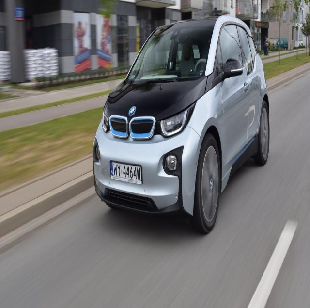

In [253]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

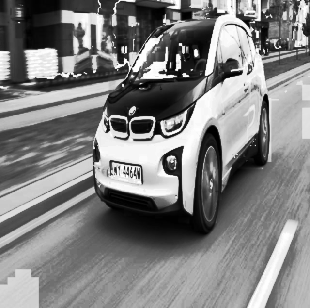

In [254]:
from twm_proj.implementation import initial_filter

importlib.reload(initial_filter)

filtered = initial_filter.InitialFilter().filter(image)
show(filtered)

## Edge filter

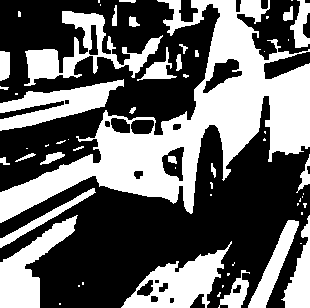

In [255]:
from twm_proj.implementation import edge_filter
importlib.reload(edge_filter)

edges = edge_filter.EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 69
example contour:
 [[122 630]
 [122 632]
 [124 632]
 [124 630]]


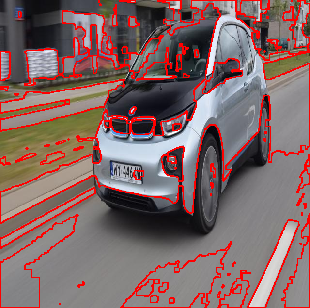

In [256]:
from twm_proj.implementation.contour_detector import ContourDetector

contours = [*ContourDetector().detect(edges)]
print("contours count:", len(contours))
print("example contour:\n", contours[0])
show_contours(image, contours)

## Rectangle detection

rects count: 2
example rect:
 [[510 639]
 [548 639]
 [616 460]
 [593 459]]


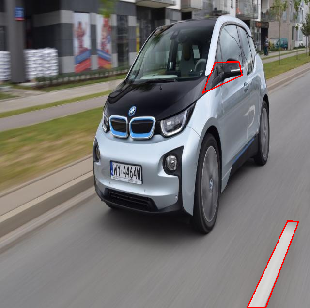

In [257]:
from twm_proj.implementation import rect_detector

importlib.reload(rect_detector)

rects = [rect_detector.RectDetector().detect(contour) for contour in contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0] if rects else None)
show_contours(image, rects)

## Rectangle transforming

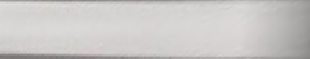

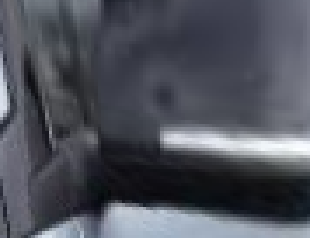

In [258]:
from twm_proj.implementation.rect_transformer import RectTransformer

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
for rect_image in rect_images:
    show(rect_image)

## Rectangle classification

In [259]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    rect
    for rect, cls in zip(rect_images, rect_classes)
    if cls != RectangleType.NOT_PLATE
]

[('ONE_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.14230769230769227,
   <RectangleType.TWO_ROW_PLATE: 2>: 2.6559102674719584,
   <RectangleType.MINI_PLATE: 3>: 0.8857142857142857}),
 ('TWO_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.7172240802675586,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.09498693276312666,
   <RectangleType.MINI_PLATE: 3>: 0.5331953071083506})]

## Pre-OCR processing

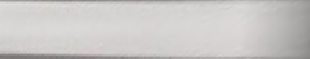

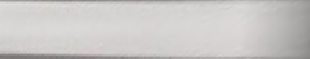

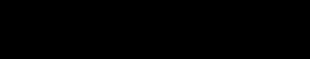

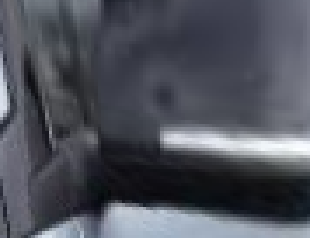

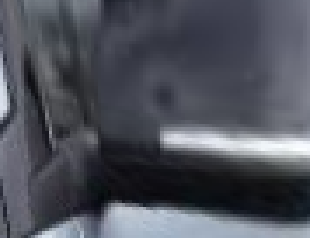

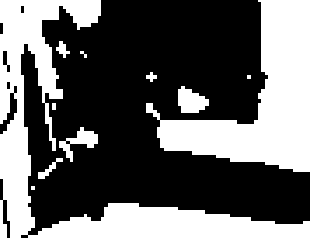

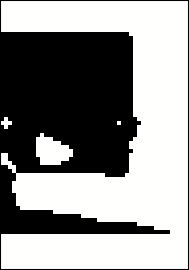

In [260]:
from notebooks.utils import show_collage
from twm_proj.implementation import pre_ocr

importlib.reload(pre_ocr)

plate_letters = []

for plate in plates:
    show(plate)
    plate = pre_ocr.PreOcr().cut(plate)
    show(plate)
    plate = pre_ocr.PreOcr().to_grayscale(plate)
    show(plate)

    letters = [*pre_ocr.PreOcr().get_letters(plate)]
    show_collage(letters, col_wrap=len(letters))

    plate_letters.append(letters)

## OCR

In [261]:
from twm_proj.implementation.ocr import Ocr


for letters in plate_letters:
    scanned_text = Ocr().scan_text(letters)
    print(scanned_text if scanned_text else None)

None
J
